Подготовить данные для этапа моделирования (обучения)

1. Анализ данных, необходимые корректировки.
2. Обработать пропуски.
3. Оценить выбросы.
4. Корреляция.
5. Тест на нормальность распределения.
6. Масштабировать и стандартизировать данные.
7. Разделите данные на тренрровачную и тестовую выборку.
8. При обработке пропусков/выбросов/скалировании тестовую и тренировачную выборку обрабатывать отдельно.

In [245]:
import pandas as pd
import scipy as sp
from RegionCodeService import RegionTokenService

pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 320)
pd.set_option('display.width', 80)

import re

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

from scipy import stats

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Описание

Требуется предсказать, выберет ли покупатель магазина электроники и бытовой техники кредит от Tinkoff.ru. Банк работает с сетью магазинов, в которой также присутствуют и другие кредитные организации. Онлайн-заявка на кредит от покупателя поступает одновременно в несколько банков, часть из которых ее одобряют. После этого покупатель выбирает, в каком банке взять кредит. Результатом ML-моделирования является число, которое означает вероятность выбора кредита конкретным покупателем.

**Категориальные**
* Образование (education)
* Работа (job_position)
* Семейное положение (martial_status)
* Номер предполагаемого тарифа (tarrif_id)
* Регион проживания (living_region)
* пол (gender)

**Вещественные**
* Возраст (age)
* Сумма кредита (credit_sum)
* Срок кредитования (credit_month)
* Месячный заработок (montly_income)
* Количество кредитов у клиента (credit_count)
* Количество просроченных кредитов клиента (over_due_credit_count)


In [246]:
source = pd.read_csv('credit_train.csv', encoding='cp1251', sep=';', decimal=",")
df = source.copy()

In [247]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170746 entries, 0 to 170745
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   client_id             170746 non-null  int64  
 1   gender                170746 non-null  object 
 2   age                   170743 non-null  float64
 3   marital_status        170743 non-null  object 
 4   job_position          170746 non-null  object 
 5   credit_sum            170744 non-null  float64
 6   credit_month          170746 non-null  int64  
 7   tariff_id             170746 non-null  object 
 8   score_shk             170739 non-null  float64
 9   education             170741 non-null  object 
 10  living_region         170554 non-null  object 
 11  monthly_income        170741 non-null  float64
 12  credit_count          161516 non-null  float64
 13  overdue_credit_count  161516 non-null  float64
 14  open_account_flg      170746 non-null  int64  
dtype

In [248]:
df['job_position'].unique()

array(['UMN', 'SPC', 'INP', 'DIR', 'ATP', 'PNA', 'BIS', 'WOI', 'NOR',
       'WRK', 'WRP', 'PNV', 'BIU', 'PNI', 'HSK', 'PNS', 'INV', 'ONB'],
      dtype=object)

### Обработка региона проживания

Регион проживания имеет слабо пересекаищиеся данные из за разности написания названия региона
Обрабатываем под общий контракт пеоеводя в индекс региона, также есть уже несуществующие регионы их приводим к существующим

In [249]:
region_code_service = RegionTokenService("codes.txt")
df['living_region'] = df['living_region'].map(lambda x: region_code_service.map_code(x))
df

,client_id,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
0,1,M,NaN,NaN,UMN,59998.00,10,1.6,NaN,GRD,23,30000.0,1.0,1.0,0
1,2,F,NaN,MAR,UMN,10889.00,6,1.1,NaN,NaN,96,NaN,2.0,0.0,0
2,3,M,32.0,MAR,SPC,10728.00,12,1.1,NaN,NaN,64,NaN,5.0,0.0,0
3,4,F,27.0,NaN,SPC,12009.09,12,1.1,NaN,NaN,34,NaN,2.0,0.0,0
4,5,M,45.0,NaN,SPC,NaN,10,1.1,0.421385,SCH,74,NaN,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170741,170742,F,27.0,UNM,SPC,64867.00,12,1.1,0.535257,GRD,16,40000.0,6.0,0.0,0
170742,170743,F,24.0,MAR,SPC,17640.00,6,1.6,0.573287,SCH,93,30000.0,1.0,0.0,0
170743,170744,F,31.0,UNM,SPC,27556.47,10,1.32,0.416098,GRD,25,40000.0,1.0,0.0,0
170744,170745,F,53.0,DIV,PNA,6189.00,12,1.1,0.482595,SCH,58,31000.0,2.0,0.0,0


## Обработка колонки tariff_id
Колонка содержит по сути категориальные данные но выглядят как вещественные числа, преобразуем тарифы в int

In [250]:
df['tariff_id'].unique()
df['tariff_id'] = df['tariff_id'].map(lambda x: int((float(x)*100)-100))
df['tariff_id'].unique()

array(['1.6', '1.1', '1.5', '1.0', '1.32', '1.4', '1.7', '1.3', '1.16',
       '1.9', '1.22', '1.23', '1.43', '1.44', '1.19', '1.20', '1.21',
       '1.24', '1.2', '1.91', '1.41', '1.17', '1.94', '1.25', '1.48',
       '1.52', '1.18', '1.26', '1.27', '1.28', '1.96', '1.56', '1.29'],
      dtype=object)

array([60, 10, 50,  0, 32, 40, 70, 30, 15, 90, 22, 23, 43, 44, 19, 20, 21,
       24, 91, 41, 17, 94, 25, 48, 52, 18, 26, 27, 28, 96, 56, 29],
      dtype=int64)

## Обработка дубликатов
дубликаты удалим

In [251]:
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170746 entries, 0 to 170745
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   client_id             170746 non-null  int64  
 1   gender                170746 non-null  object 
 2   age                   170743 non-null  float64
 3   marital_status        170743 non-null  object 
 4   job_position          170746 non-null  object 
 5   credit_sum            170744 non-null  float64
 6   credit_month          170746 non-null  int64  
 7   tariff_id             170746 non-null  int64  
 8   score_shk             170739 non-null  float64
 9   education             170741 non-null  object 
 10  living_region         170746 non-null  int64  
 11  monthly_income        170741 non-null  float64
 12  credit_count          161516 non-null  float64
 13  overdue_credit_count  161516 non-null  float64
 14  open_account_flg      170746 non-null  int64  
dtype

Удалим колонку clien_id так как она не несет какой-либо информации

In [252]:
df = df.drop('client_id', axis=1)

# Обработка пропусков

Обрабатываем пропуски категориальных признаков
для семейного положения, образования, региона проживания, пропусков здесь не много заполняем наиболее частыми значениями
подставляя наиболее часто встречаемое значение

In [253]:
df['marital_status'] = df['marital_status'].fillna(df['marital_status'].mode()[0])
df['education'] = df['education'].fillna(df['education'].mode()[0])
df['living_region'] = df['living_region'].fillna(df['living_region'].mode()[0])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170746 entries, 0 to 170745
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   gender                170746 non-null  object 
 1   age                   170743 non-null  float64
 2   marital_status        170746 non-null  object 
 3   job_position          170746 non-null  object 
 4   credit_sum            170744 non-null  float64
 5   credit_month          170746 non-null  int64  
 6   tariff_id             170746 non-null  int64  
 7   score_shk             170739 non-null  float64
 8   education             170746 non-null  object 
 9   living_region         170746 non-null  int64  
 10  monthly_income        170741 non-null  float64
 11  credit_count          161516 non-null  float64
 12  overdue_credit_count  161516 non-null  float64
 13  open_account_flg      170746 non-null  int64  
dtypes: float64(6), int64(4), object(4)
memory usage: 19.

Обрабатываем пропуски
подставляя среднее значение

In [254]:
df['age'] = df['age'].fillna(df['age'].mean())
df['credit_sum'] = df['credit_sum'].fillna(df['credit_sum'].mean())
df['score_shk'] = df['score_shk'].fillna(df['score_shk'].mean())
df['monthly_income'] = df['monthly_income'].fillna(df['monthly_income'].mean())
df['credit_count'] = df['credit_count'].fillna(df['credit_count'].mean())
df['overdue_credit_count'] = df['overdue_credit_count'].fillna(df['overdue_credit_count'].mean())
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170746 entries, 0 to 170745
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   gender                170746 non-null  object 
 1   age                   170746 non-null  float64
 2   marital_status        170746 non-null  object 
 3   job_position          170746 non-null  object 
 4   credit_sum            170746 non-null  float64
 5   credit_month          170746 non-null  int64  
 6   tariff_id             170746 non-null  int64  
 7   score_shk             170746 non-null  float64
 8   education             170746 non-null  object 
 9   living_region         170746 non-null  int64  
 10  monthly_income        170746 non-null  float64
 11  credit_count          170746 non-null  float64
 12  overdue_credit_count  170746 non-null  float64
 13  open_account_flg      170746 non-null  int64  
dtypes: float64(6), int64(4), object(4)
memory usage: 19.

### Обогащение датасета
Ввод новой колонки отношение credit_sum к credit_month

In [255]:
df['credit_sum_per_month'] = df.apply(lambda row: row.credit_sum/row.credit_month, axis=1)
df['credit_sum_per_month']

0         5999.800000
1         1814.833333
2          894.000000
3         1000.757500
4         2609.509754
             ...     
170741    5405.583333
170742    2940.000000
170743    2755.647000
170744     515.750000
170745    1278.700000
Name: credit_sum_per_month, Length: 170746, dtype: float64

In [256]:
df.groupby(['job_position'])['monthly_income'].mean()

job_position
ATP    29717.366894
BIS    59557.449758
BIU    41508.730159
DIR    67521.516267
HSK    31250.000000
INP    65553.941909
INV    25680.000000
NOR    36650.975791
ONB    17000.000000
PNA    22575.575846
PNI    20367.692308
PNS    39591.666667
PNV    23335.300000
SPC    38112.021472
UMN    49431.779427
WOI    35983.678977
WRK    37029.185976
WRP    38859.827273
Name: monthly_income, dtype: float64

введем новую колонку наличие "хорошей" работы, хорошую работы выберем как работу у которая средняя зп по датасету > 50000

In [257]:
# good_jobs = {'INP', 'BIS', 'DIR'}
# df['good_job'] = df.apply(lambda row: 1 if row.job_position in good_jobs else 0, axis=1)
# df

введем новую колонку наличие "плохой" работы, плохая работы выберем как работу у которая средняя зп по датасету < 20000

In [258]:
# bad_jobs = {'PNI', 'ONB'}
# df['bad_job'] = df.apply(lambda row: 1 if row.job_position in bad_jobs else 0, axis=1)

## Заменяем категориальные колонки на числовой код методом подстановки

In [259]:
gender_dict = {'F': 0, 'M': 1}
df['gender'] = df['gender'].map(lambda x: gender_dict[x])

marital_status_dict = {'MAR': 1, 'UNM': 2, 'DIV': 3, 'WID': 4, 'CIV': 5}
df['marital_status'] = df['marital_status'].map(lambda x: marital_status_dict[x] if x == x else x)

job_dictionary = {'UMN': 0, 'SPC': 1, 'INP': 2, 'DIR': 3, 'ATP': 4, 'PNA': 5, 'BIS': 6, 'WOI': 7, 'NOR': 8, 'WRK': 9,
                  'WRP': 10, 'PNV': 11, 'BIU': 12, 'PNI': 13, 'HSK': 14, 'PNS': 15, 'INV': 16, 'ONB': 17}
df['job_position'] = df['job_position'].map(lambda x: job_dictionary[x])

education_dict = {'GRD': 0, 'SCH': 2, 'UGR': 3, 'PGR': 4, 'ACD': 5}
df['education'] = df['education'].map(lambda x: education_dict[x] if x == x else x)
df['tariff_id'] = df['tariff_id'].astype('float64')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170746 entries, 0 to 170745
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   gender                170746 non-null  int64  
 1   age                   170746 non-null  float64
 2   marital_status        170746 non-null  int64  
 3   job_position          170746 non-null  int64  
 4   credit_sum            170746 non-null  float64
 5   credit_month          170746 non-null  int64  
 6   tariff_id             170746 non-null  float64
 7   score_shk             170746 non-null  float64
 8   education             170746 non-null  int64  
 9   living_region         170746 non-null  int64  
 10  monthly_income        170746 non-null  float64
 11  credit_count          170746 non-null  float64
 12  overdue_credit_count  170746 non-null  float64
 13  open_account_flg      170746 non-null  int64  
 14  credit_sum_per_month  170746 non-null  float64
dtype

### Оценка выбросов

<Figure size 2160x1440 with 0 Axes>

<AxesSubplot:>

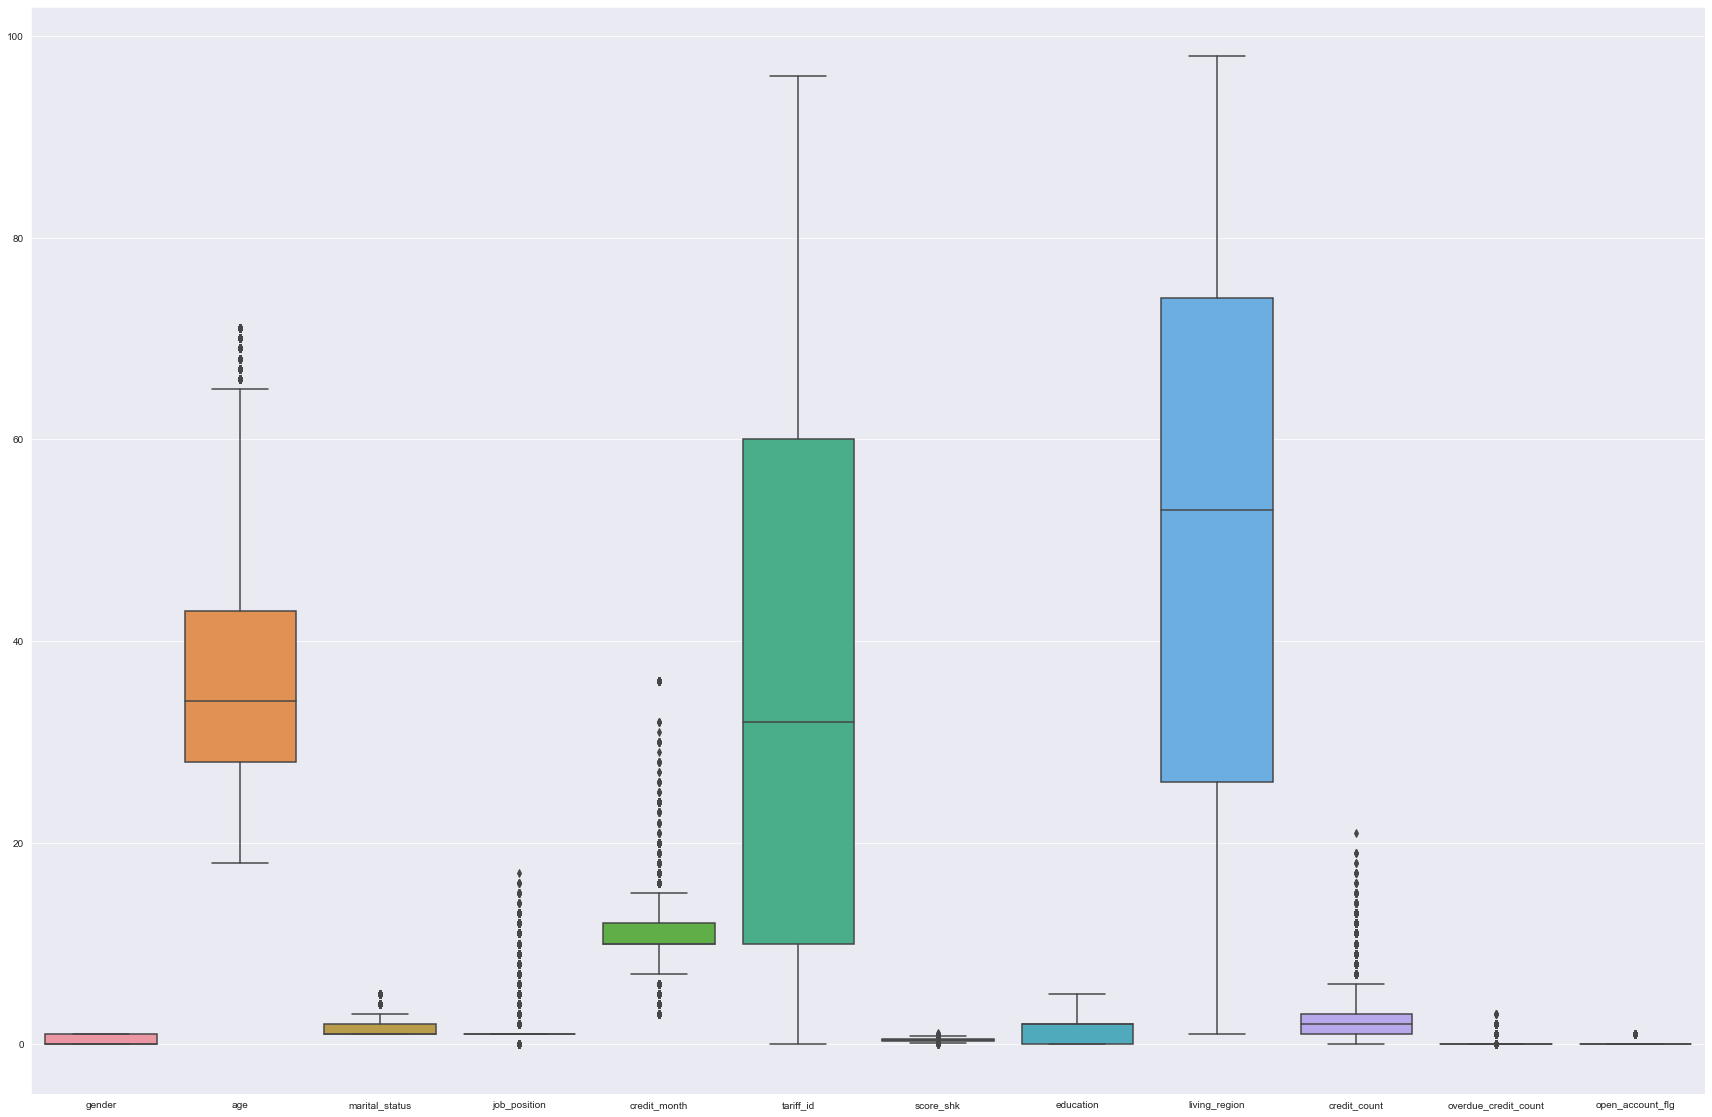

In [260]:
plt.figure(figsize=(30, 20))
sns.boxplot(data=df[['gender', 'age', 'marital_status', 'job_position', 'credit_month', 'tariff_id', 'score_shk', 'education', 'living_region', 'credit_count', 'overdue_credit_count', 'open_account_flg']])

### Кореляции

<Figure size 2160x1440 with 0 Axes>

<AxesSubplot:>

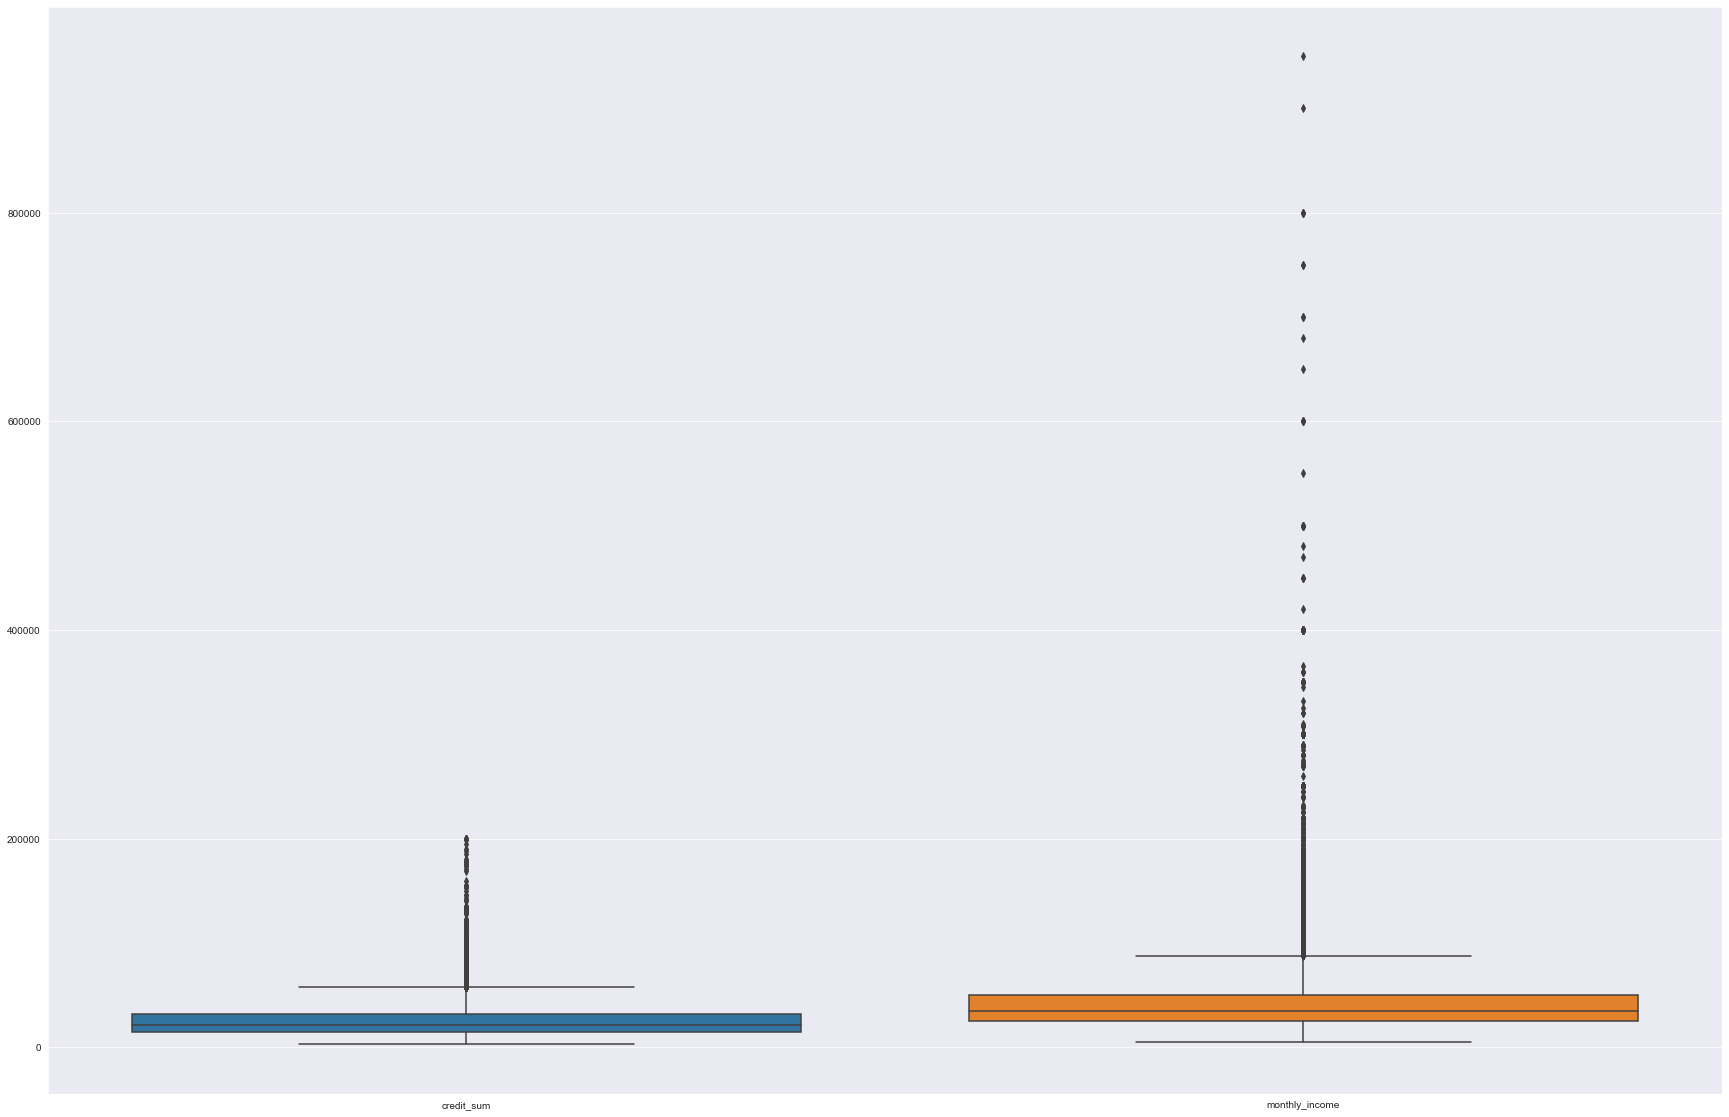

In [261]:
plt.figure(figsize=(30, 20))
sns.boxplot(data=df[['credit_sum', 'monthly_income']])

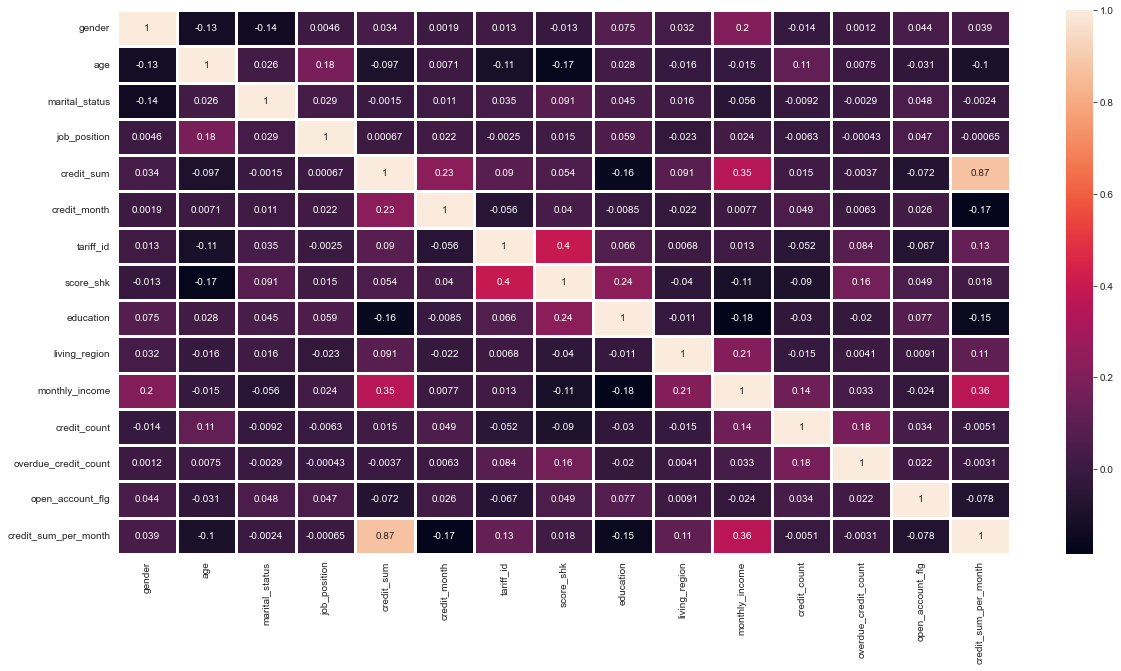

In [262]:
plt.figure(figsize=(20, 10))
sns.heatmap(df.corr(), annot=True, linewidths=3);

In [263]:
### ТЕСТ на нормальность

In [264]:
def normal_test(series, alpha = 0.05):
    stat, p = sp.stats.shapiro(series)
    return p > alpha

for column in ['age', 'credit_sum', 'credit_month', 'score_shk', 'monthly_income', 'credit_count', 'overdue_credit_count']:
    if normal_test(df[column]):
        print(f'{column}: Похоже на нормальное распределение')
    else:
        print(f'{column}: Не похоже на нормальное распределение')


age: Не похоже на нормальное распределение
credit_sum: Не похоже на нормальное распределение
credit_month: Не похоже на нормальное распределение
score_shk: Не похоже на нормальное распределение
monthly_income: Не похоже на нормальное распределение
credit_count: Не похоже на нормальное распределение
overdue_credit_count: Не похоже на нормальное распределение


C:\Users\Nikolay\anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [265]:
# Разделение данных на обучающую и тестовую выборки
y = df.open_account_flg
X = df.drop(['open_account_flg'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                      train_size=0.8,
                                                      random_state=42)

In [266]:
# # Препроцессинг для числовых переменных
# numerical_transformer = QuantileTransformer(output_distribution='normal')
#
# preprocessor = ColumnTransformer(transformers=[('num',
#                                                 numerical_transformer,
#                                                 num_columns)])

In [267]:
# Модель RandomForest
forest = RandomForestClassifier(n_estimators=800, max_depth=17,
                                random_state=2020, n_jobs=-1)

In [268]:
my_pipeline = Pipeline(steps=[('model', forest)])
my_pipeline.fit(X_train, y_train);

preds = my_pipeline.predict(X_test)

# Оценка модели
score_auc = roc_auc_score(y_test, preds)
print('AUC: ', score_auc)

Pipeline(steps=[('model',
                 RandomForestClassifier(max_depth=17, n_estimators=800,
                                        n_jobs=-1, random_state=2020))])

AUC:  0.5356768497293452


In [269]:
forest.fit(X_train, y_train);

print('AUC на обучающей выборке: {:.3f}'.
      format(roc_auc_score(y_train, forest.predict_proba(X_train)[:, 1])))
print('AUC на контрольной выборке: {:.3f}'.
      format(roc_auc_score(y_test, forest.predict_proba(X_test)[:, 1])))

RandomForestClassifier(max_depth=17, n_estimators=800, n_jobs=-1,
                       random_state=2020)

AUC на обучающей выборке: 0.935
AUC на контрольной выборке: 0.763
